In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<h1 style = "font-size: 42px; text-align: center;"> Data Overview </h1>

<h2 style = "text-align: center;"> Notebook inspecting the cell cycle time-series data and explaining the effects of track extraction and filtering scripts for deep learning and data analysis </h2>

## 1 - Data Introduction

The data was acquired through time-lapse microscopy via live-cell fluorescence imaging. The cells are placed in compartments of multi-well plates and some well compartments have been concentrations of cell cycle perturbation molecules we refer to as the condition or drug of the well. Each well was imaged with a time resolution $dt = 5mins$, where cells were segmented and tracked for a total simulation time of $3\;days$ or $72.25h$. 

A cell track corresponds to the same cell imaged over time. This collection of images is a 4-dimensional tensor of shape $(T, C, H, W)$ where $T$ is track length, $C$ is number of channels, $H$, $W$ are image dimensions. Our data has 5 channels in the following order $(PC, FG, FR, BF, H2B)$ where $BF$ & $PC$ are Bright-field and Phase Contrast images of the cell, $FR$ & $FG$ are the fluorescent cell cycle markers and $H2B$ is a nuclear marker used for cell segmentation. 

46 wells, 135971 cell tracks, 12629821 cell images


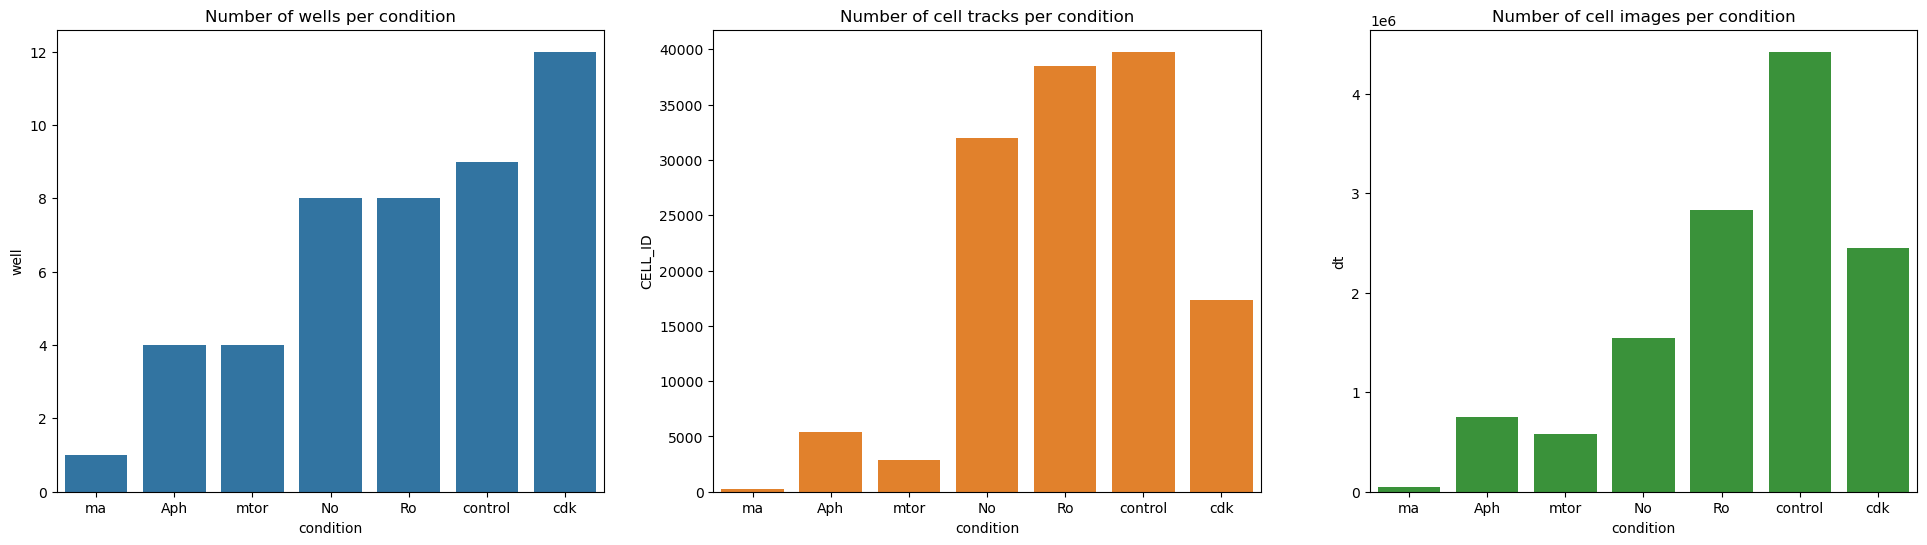

In [2]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))
# Let's take a look at our wells and the number of tracked cells with well_conditions.csv and the CTC Trackmate outputs

well_conditions = pd.read_csv('well_conditions.csv', dtype=str)
wells_per_condition = well_conditions.groupby('condition').count().reset_index().sort_values('well')
sns.barplot(wells_per_condition, x="condition", y="well", ax=ax[0])

# Let's take a look at the number of cell tracks per well, we have run two multi-well plate experiments with different data paths

PATH = {1:"/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/260124-RPE-timelapse/Stitched/",2:"/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/21062024_RPE_before_after_inhibitors/Aligned/"}
trackmate_results = pd.DataFrame(); conditions_dict = dict(zip(well_conditions['well'], well_conditions['condition']))
for path in list(PATH.values()): 
    wells = sorted([well.split('.')[0] for well in os.listdir(path) if well.endswith('.tif')])
    for well_id in wells:
        well_results = pd.read_csv(f"{path}Tracked/CTC_results/{well_id}/01_RES/res_track.txt", sep = " ", header= None, names = ["CELL_ID", "T_START", "T_END", "PARENT"])
        well_results['CELL_ID'] = well_results['CELL_ID'].apply(lambda cid: f"{well_id}.{cid}"); trackmate_results = pd.concat([trackmate_results, well_results])

conditions_dict = dict(zip(well_conditions['well'], well_conditions['condition']))
trackmate_results['condition'] = trackmate_results['CELL_ID'].apply(lambda cid: conditions_dict[cid.split('.')[0]])

sns.barplot(trackmate_results.groupby('condition').count().reset_index(), x="condition", y="CELL_ID", ax=ax[1], order=wells_per_condition['condition'].values, color=sns.color_palette()[1])

# Let's take a look at the number of cell images per well, have a better idea of the length of these tracks

trackmate_results['dt'] = trackmate_results.apply(lambda row: row['T_END']-row['T_START'], axis=1)
sns.barplot(trackmate_results.groupby('condition')['dt'].sum().reset_index(), x="condition", y="dt", ax=ax[2], order=wells_per_condition['condition'].values, color=sns.color_palette()[2])
print(f"{len(well_conditions)} wells, {len(trackmate_results)} cell tracks, {trackmate_results['dt'].sum()} cell images")
ax[0].set_title('Number of wells per condition'); ax[1].set_title('Number of cell tracks per condition'); ax[2].set_title('Number of cell images per condition');plt.show()

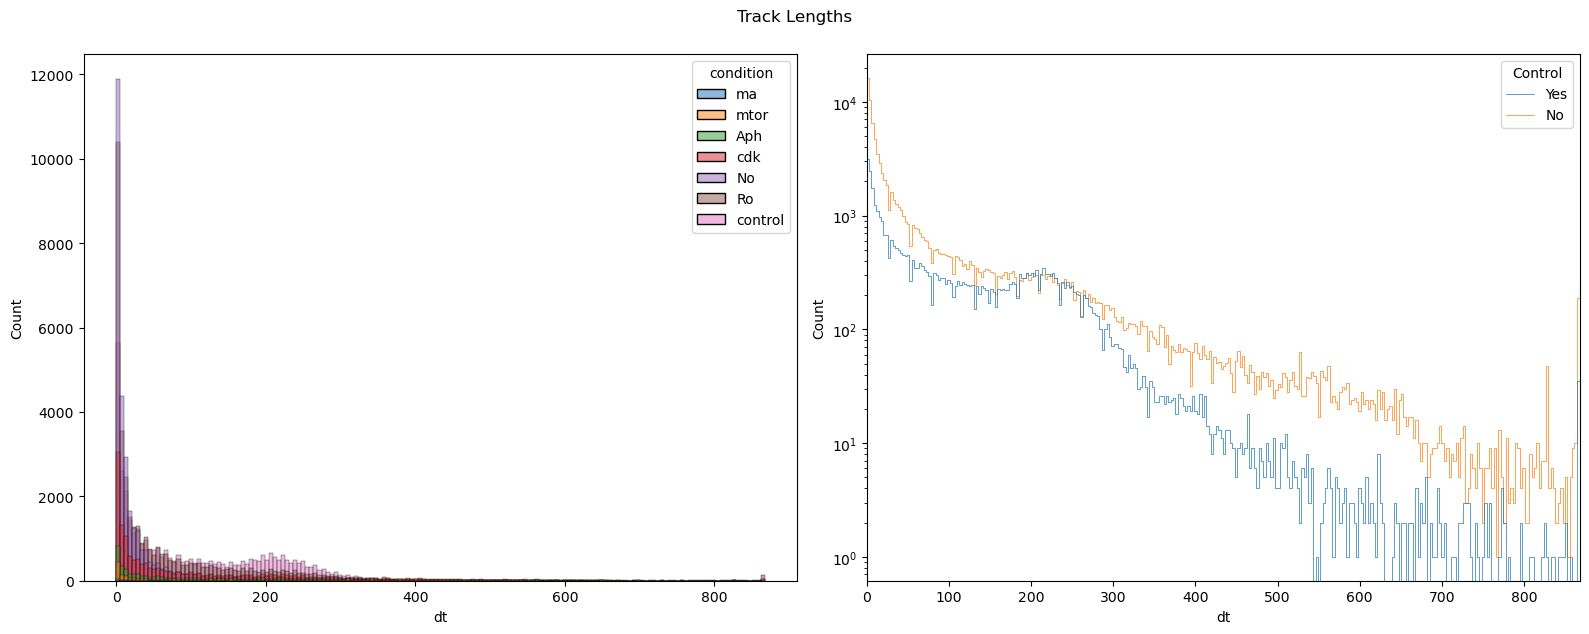

In [3]:
#Let's have a look at the distribution of cell track lengths

fig, ax = plt.subplots(1, 2, figsize = (16, 6));trackmate_results['Control'] = trackmate_results['condition'].apply(lambda cond: 'Yes' if cond == 'control' else 'No')
condition_order_most_tracks = trackmate_results.groupby('condition').count().reset_index().sort_values('CELL_ID')['condition'].values.tolist()
sns.histplot(trackmate_results, x='dt', hue='condition', multiple="layer", ax=ax[0], stat='count', hue_order = condition_order_most_tracks)
sns.histplot(trackmate_results, x='dt', hue='Control', multiple="layer", element='step', ax=ax[1], fill=False, lw=0.5, stat='count', bins=300)
ax[1].set_yscale('log');ax[1].set_xlim(0, 868);plt.tight_layout();plt.suptitle('Track Lengths', y=1.05);plt.show()

## 2 - Track Extraction

The script ```track_extraction.py``` outputs for each well 2 pickled dataframes: ```images.pkl```, ```channels.pkl```. These contain cropped out cell images and integrated channel values from the original well film as well as positional information on a cell.
During this script, we chose to keep only tracks with atleast $72dt$ to discard tracking errors with cells that are tracked for atleast $6h$.

<details>
    <summary>Code to get channels from all wells: <code> merged_channels.pkl </code> </summary>
 <pre>
  <code>
EXTRACTION_PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/extraction/"; wells = sorted(os.listdir(EXTRACTION_PATH)); extraction_results = pd.DataFrame()
for well_id in wells:
    channels = pd.read_pickle(f'{EXTRACTION_PATH}{well_id}/channels.pkl')
    channels['CELL_ID'] = channels['CELL_ID'].apply(lambda cid: f"{well_id}.{cid}"); extraction_results = pd.concat([extraction_results, channels])
extraction_results['condition'] = extraction_results['CELL_ID'].apply(lambda cid: conditions_dict[cid.split('.')[0]])
extraction_results.to_pickle("/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/merged_channels.pkl")</code>
</pre>   
</details>


In [4]:
#Let's have a look at how many cell tracks and cell images we're left with. We can have a look at the dataframe of integrated channels; channels.pkl for now. 
extraction_results = pd.read_pickle("/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/merged_channels.pkl")

,CELL_ID,FRAME,CHANNEL_SUM,CHANNEL_MEAN,CHANNEL_MEDIAN,CHANNEL_STD,T_START,T_END,DELTA_T,AREA,POSITION,RADIUS,PARENT,condition
284910,0610.2080,660,"[191423, 1186150, 3239481, 10024200, 1229761]","[328.9, 2038.1, 5566.1, 17223.7, 2113.0]","[320.0, 2152.5, 5905.5, 17264.5, 2160.0]","[79.11976873588827, 529.8133627385522, 1393.08...",554,788,234,582,"[1344.5, 2577.4]",14.8,2078,control


50467 cell tracks, 11168306 cell images


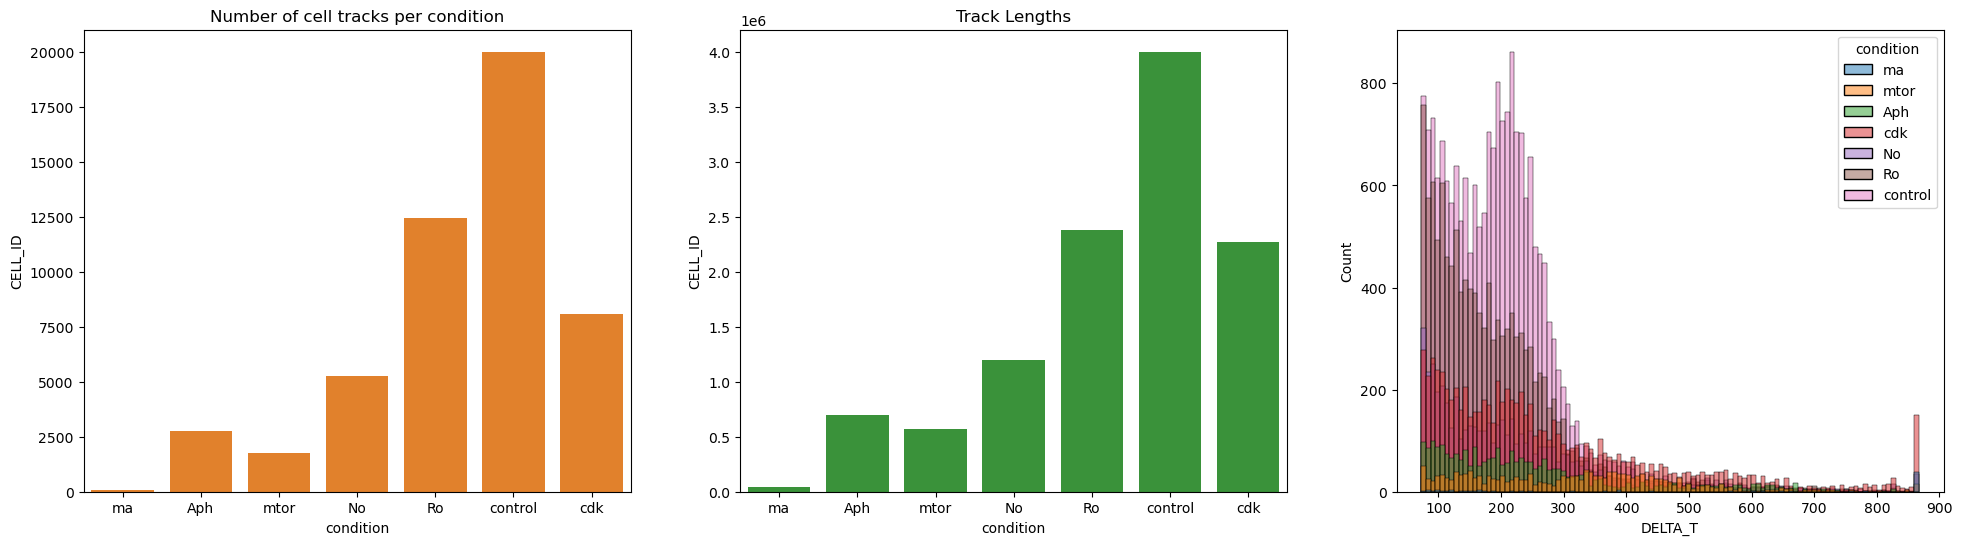

In [5]:
display(extraction_results.sample())
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

unique_tracks = extraction_results.drop_duplicates(subset='CELL_ID').reset_index(drop=True)
sns.barplot(unique_tracks.groupby('condition').count().reset_index(), x="condition", y="CELL_ID", ax=ax[0], order=wells_per_condition['condition'].values, color=sns.color_palette()[1])
sns.barplot(extraction_results.groupby('condition').count().reset_index(), x="condition", y="CELL_ID", ax=ax[1], order=wells_per_condition['condition'].values, color=sns.color_palette()[2])
sns.histplot(unique_tracks, x='DELTA_T', hue='condition', multiple="layer", ax=ax[2], stat='count', hue_order=condition_order_most_tracks)
print(f"{len(unique_tracks)} cell tracks, {len(extraction_results)} cell images")
ax[0].set_title('Number of cell tracks per condition'); ax[1].set_title('Number of cell images per condition'); ax[2].set_title('Track Lengths'); plt.show()

In [6]:
#Lets take a look at the cell fluorescent profiles of these cells
track_df = pd.DataFrame(extraction_results.groupby('CELL_ID').apply(lambda cell: pd.Series({'FRAME': cell['FRAME'].values.tolist(), 'CHANNEL_SUM': cell['CHANNEL_SUM'].values.tolist(),'AREA': cell['AREA'].values.tolist(),
                                                                                            'POSITION': cell['POSITION'].values.tolist(),'condition': cell['condition'].values.tolist()[0],'PARENT': cell['PARENT'].values.tolist()[0],})).reset_index())

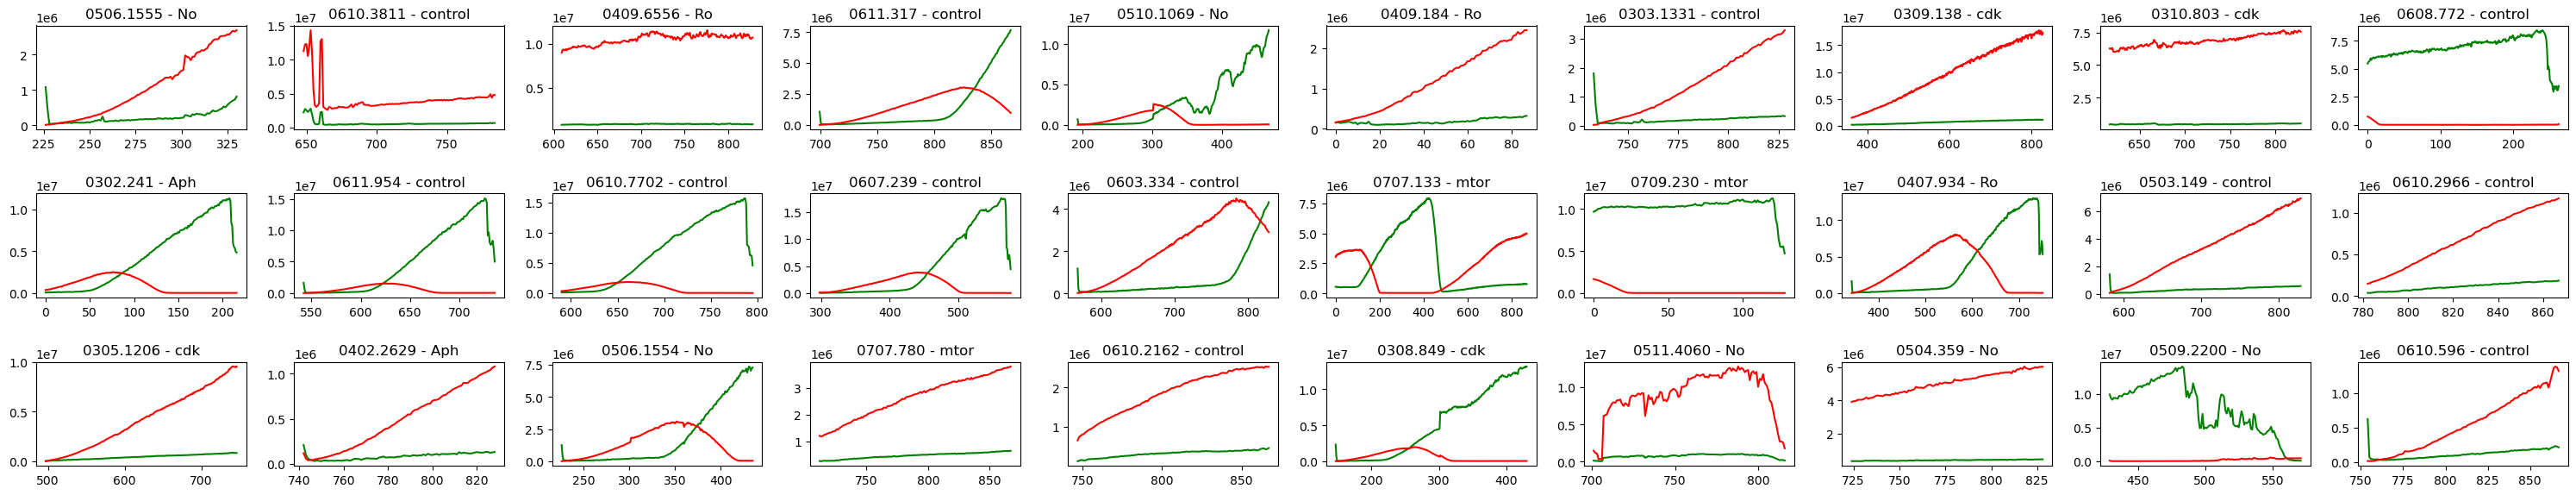

In [7]:
def visualize_tracks(track_df, number, per_row = 10, out=None): 
    fig, ax = plt.subplots(number//10, per_row, figsize = (per_row*3, number//10 * 2)); ax = ax.flatten()
    tracks = track_df.sample(len(ax)).reset_index(drop=True)
    for i in range(len(ax)): track = np.array(tracks.loc[i, 'CHANNEL_SUM']); ax[i].plot(tracks.loc[i, 'FRAME'], track[:, 1], 'green', tracks.loc[i, 'FRAME'], track[:, 2], 'red'); ax[i].set_title(f'{tracks.loc[i, "CELL_ID"]} - {tracks.loc[i, "condition"]}')
    plt.tight_layout()
    if out is not None: plt.savefig(out, bbox_inches='tight', dpi=200); plt.close()
    plt.show()

visualize_tracks(track_df, 30);# visualize_tracks(track_df, 1000, out='extraction_tracks.png') #1min30s execution time

We can see our tracks in some cases are complete and display a full profile of fluorescent fucci markers, but others are incomplete and with variable amplitudes of the fucci signal, their phase is ambiguous. For DL & DA, we should filter out very incomplete tracks and normalize these fluorescent phase markers track-wise.   

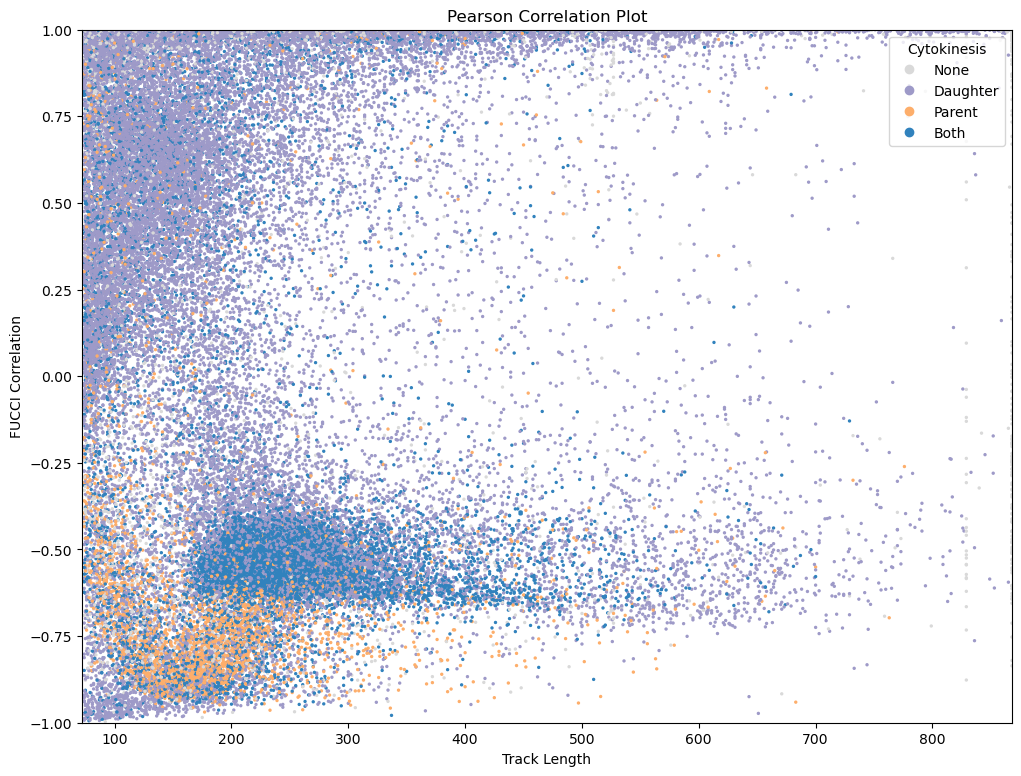

In [20]:
# Let's look at the correlation plot between the FUCCI signals of a cell
track_df['correlation'] = track_df['CHANNEL_SUM'].apply(lambda cs: np.corrcoef(np.array(cs)[:, 1], np.array(cs)[:, 2])[0, 1])
parents = set(track_df.apply(lambda track: track['CELL_ID'].split('.')[0] + '.' + str(track['PARENT']), axis=1).values.tolist())
track_df['is_parent'] = track_df['CELL_ID'].apply(lambda cid: int(cid in parents)); track_df['is_daughter'] = track_df['PARENT'].apply(lambda p: int(p > 0))
track_df['cytokinesis'] = track_df.apply(lambda cell: cell['is_parent'] << 1 | cell['is_daughter'], axis=1)
track_df['dt'] = track_df['FRAME'].apply(lambda fs: len(fs))

import matplotlib as mpl; fig, ax = plt.subplots(figsize = (12, 9))
scatter = ax.scatter(track_df['dt'], track_df['correlation'], s=2, c = track_df['cytokinesis'], cmap=mpl.colormaps['tab20c'].reversed())# c = track_df['condition'].apply(lambda c: conditions_colors[c]).values.tolist())
ax.set_xlim(72, 868); ax.set_ylim(-1, 1); ax.set_xlabel('Track Length'); ax.set_ylabel('FUCCI Correlation'); ax.set_title('Pearson Correlation Plot'); ax.legend(scatter.legend_elements()[0], ['None', 'Daughter', 'Parent', 'Both'],loc = "upper right", title="Cytokinesis")
plt.show()

In [39]:
# What would be the percentages of tracks remaining if we filtered with different slices
print('Number of Tracks:', len(track_df), '| Daughters:',  len(track_df[track_df['is_daughter'] > 0]), '| Parents:', len(track_df[track_df['is_parent'] > 0]),
      '| Both:', len(track_df[track_df['cytokinesis'] == 3]), '| Tracks with Negative FUCCI Correlation:', len(track_df[track_df['correlation'] < 0]))
print('Double Cytokinesis and Negative Correlation:', len(track_df[(track_df['cytokinesis'] == 3) & (track_df['correlation'] < 0)]))

Number of Tracks: 50467 | Daughters: 43016 | Parents: 17600 | Both: 13641 | Tracks with Negative FUCCI Correlation: 26228
Double Cytokinesis and Negative Correlation: 9670


## 3 - Track Filtering

The script ```track.filter.py``` outputs directories of datasets with training and test tracks of cell images and labels/fucci fluorescent channels ready for deep learning frameworks. 

In this script and in order: We isolate fluorescent channels for CHANNEL_SUM measure, filter out tracks on the borders of wells that weren't properly cropped, standardize cell images pixel values per channel and per image, min-max normalize the fucci values trackwise, pass the fucci values to the log scale and filter out tracks with a positive correlation between the two fucci markers and cells that aren't daughter and parent cells. 

We can explore the datasets created such as:
- healthy (collection of control cell wells)
- complete (all wells)
- drugged (drugged wells)


In [3]:
# Let's take a look at the healthy track dataset
path = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/track_datasets/healthy/"; tracks = {'train': [], 'test': []}
for subset in ['train', 'test']:
    for track_file in os.listdir(path + subset + '/labels/'): 
        #track = np.array([channel.tolist() for channel in np.load(path + subset + '/labels/' + track_file, allow_pickle=True)])
        tracks[subset].append(np.load(path + subset + '/labels/' + track_file, allow_pickle=True))

print("Remaining Control:", f"{len(tracks['train'])} Train and", f"{len(tracks['test'])} Test Tracks")

Remaining Control: 4471 Train and 315 Test Tracks


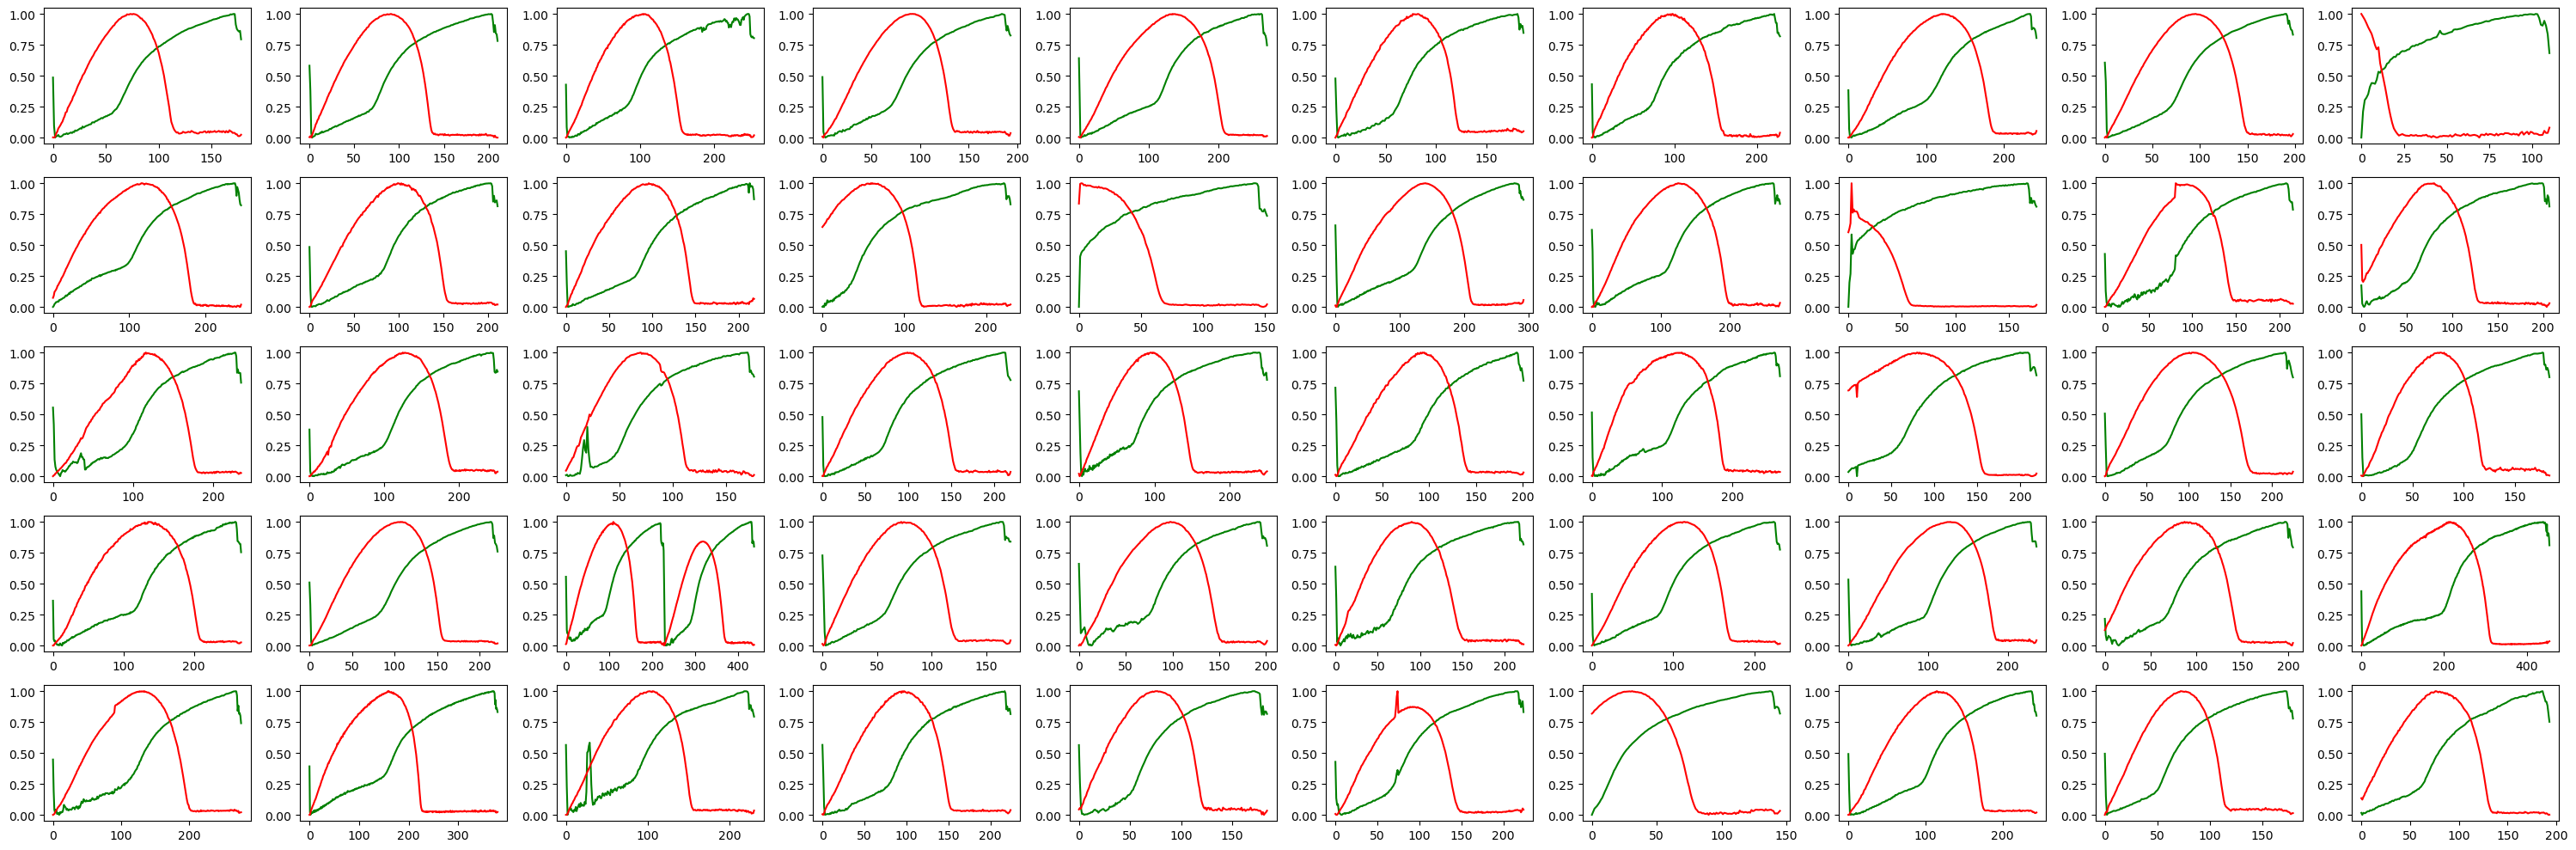

1145688


In [8]:
number = 50; per_row = 10; out = None; tracks_list = tracks['train'] + tracks['test']
fig, ax = plt.subplots(number//per_row, per_row, figsize = (per_row*3, number//per_row * 2)); ax = ax.flatten()
for i in range(len(ax)): ax[i].plot(tracks_list[i][0], 'green',tracks_list[i][1], 'red')
if out is not None: plt.savefig(out, bbox_inches='tight', dpi=100); plt.close()
plt.tight_layout(); plt.show()
print(sum([len(t[0]) for t in tracks_list]))

## 4 - Data Analysis

growth rate with parents = 0 and ratio of cells created from that res track, look at range of fucci values, fucci manifold animation, explain log information, view cell tracks images in 1 plot, take a look at cell speed and acceleration, make animation in well, deterministic phase function, histograms of cell area, tree structure. 

## 5 - Dynamic Time Warping Analysis of the Cell Cycle

In track extraction, visualize all tracks in png, fucci manifold plot and plot histograms of different amplitudes and histograms of cells and maybe 3kx3k showing cell trajectories, speed acceleration of cell. 

visualize salati all in 1

- script to output fucci profiles
- script that makes fucci manifold animation
- show extraction and filtering effects
- signal correlations, histograms of cell track lengths
- script to view cell images concatenated in 1
- negative correlation plot
- deterministic phase function
- DTW analysis and dtw distance

# 6 - Vision Models

a - cnn, efficientnet, masked autoencoder, umaps, performance


## 7 - Sequence Models
b - with mamba, cls or not, umaps, performance